In [1]:
%load_ext autoreload
%autoreload 2

### LR finder

Use LR finder from PL to find the optimal learning rate for the model given some fixed batch size

In [2]:
import os
import sys
sys.path.insert(0, os.path.abspath(".."))
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

import pytorch_lightning as pl

from helpers.pl_module import GarmentInpainterModule
from helpers.dataset import get_dataloaders

from omegaconf import OmegaConf

In [3]:
cfg = OmegaConf.load("../configs/train.yaml")

In [4]:
trn_dataloader, val_dataloader = get_dataloaders(cfg)
model = GarmentInpainterModule(cfg, trn_dataloader)

trainer = pl.Trainer(
    default_root_dir=cfg.output_dir,
    max_steps=cfg.trainer.max_steps,
    accelerator=cfg.trainer.accelerator,
    devices=cfg.trainer.devices,
    precision=cfg.trainer.precision,
    val_check_interval=cfg.trainer.val_check_interval,
    log_every_n_steps=cfg.trainer.log_every_n_steps,
    deterministic=True,
    enable_progress_bar=False,
    # avoid epoch based traing
    check_val_every_n_epoch=None, 
    max_epochs=10000,
)

tuner = pl.tuner.tuning.Tuner(trainer)

/home/cizinsky/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 20 worker processes in total. Our suggested max number of worker in current system is 10, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_instruct_pix2pix.StableDiffusionInstructPix2PixPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
/home/cizinsky/venvs/garment/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /home/cizinsky/venvs/garme

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 85 steps due to diverging loss.
Restoring states from the checkpoint path at outputs/.lr_find_f255611a-4ba9-4c0e-86c7-03886d6e70b1.ckpt
Restored all states from the checkpoint at outputs/.lr_find_f255611a-4ba9-4c0e-86c7-03886d6e70b1.ckpt


{'lr': [1e-06, 1.202264434617413e-06, 1.318256738556407e-06, 1.4454397707459273e-06, 1.5848931924611134e-06, 1.7378008287493753e-06, 1.905460717963247e-06, 2.0892961308540394e-06, 2.290867652767773e-06, 2.51188643150958e-06, 2.7542287033381663e-06, 3.019951720402016e-06, 3.311311214825911e-06, 3.6307805477010137e-06, 3.981071705534972e-06, 4.36515832240166e-06, 4.786300923226383e-06, 5.248074602497725e-06, 5.754399373371569e-06, 6.309573444801933e-06, 6.918309709189363e-06, 7.585775750291837e-06, 8.317637711026711e-06, 9.120108393559096e-06, 9.999999999999999e-06, 1.0964781961431852e-05, 1.202264434617413e-05, 1.3182567385564073e-05, 1.4454397707459272e-05, 1.584893192461113e-05, 1.737800828749375e-05, 1.9054607179632474e-05, 2.0892961308540396e-05, 2.2908676527677732e-05, 2.5118864315095795e-05, 2.754228703338166e-05, 3.0199517204020158e-05, 3.311311214825911e-05, 3.630780547701014e-05, 3.9810717055349735e-05, 4.365158322401658e-05, 4.7863009232263824e-05, 5.248074602497725e-05, 5.754

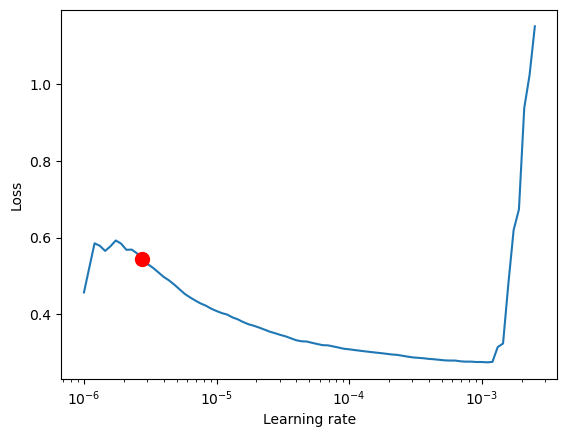

In [6]:
# Run learning rate finder
lr_finder = tuner.lr_find(model, trn_dataloader, min_lr=1e-6, max_lr=1e-2, num_training=100, update_attr=False)

# Results can be found in
print(lr_finder.results)

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()

In [7]:
new_lr

2.7542287033381663e-06